## Контекст
Сокращение детской смертности отражено в нескольких Целях устойчивого развития ООН и является ключевым индикатором человеческого прогресса.
ООН ожидает, что к 2030 году страны покончат с предотвратимой смертностью новорожденных и детей в возрасте до 5 лет, при этом все страны стремятся снизить смертность детей в возрасте до 5 лет как минимум до 25 на 1000 живорождений.

Параллельно понятию детской смертности, конечно же, существует материнская смертность, на долю которой приходится 295 000 смертей во время и после беременности и родов (по состоянию на 2017 год). Подавляющее большинство этих смертей (94%) произошло в странах с ограниченными ресурсами, и большинство из них можно было предотвратить .

В свете вышеизложенного кардиотокограммы (КТГ) представляют собой простой и доступный по цене вариант оценки здоровья плода, позволяющий медицинским работникам принять меры по предотвращению детской и материнской смертности. Само оборудование работает, посылая ультразвуковые импульсы и считывая их реакцию, тем самым проливая свет на частоту сердечных сокращений плода (ЧСС), движения плода, сокращения матки и многое другое.

## Данные
Этот набор данных содержит 2126 записей особенностей, извлеченных из исследований кардиотокографии, которые затем были классифицированы тремя экспертами-акушерами на 3 класса :
- Нормальный
- Подозревать
- Патологический

<u>FHR — fetal heart rate.</u>

## Оценивание
Производить оценку модели будем при помощи метрики F1.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import warnings
import mlflow
import mlflow.sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from boruta import BorutaPy
from mlflow.models import infer_signature

In [3]:
# задаем единый рандом стейт для воспроизводимости
RANDOM_STATE = 999

# для удобства отключим предупреждения
warnings.filterwarnings('ignore')

# отключим ненужный вывод для optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# конфигурация mlflow для трекинга
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("fetal-health-experiments")

<Experiment: artifact_location='mlflow-artifacts:/480364866770921421', creation_time=1719291753106, experiment_id='480364866770921421', last_update_time=1719291753106, lifecycle_stage='active', name='fetal-health-experiments', tags={}>

In [4]:
try:
    df_raw = pd.read_csv('../raw_data/fetal_health.csv')
except:
    raise Exception('Something is wrong. Check the file')

## Знакомство и предобработка данных

In [6]:
def get_dataset_info(df: pd.DataFrame) -> None:
    '''
    Функция принимает датафрейм Pandas
    и одной ячейкой выводит самую базовую инфу по нему
    Аргументы:
    df -- pd.DataFrame (датафрейм Pandas)
    '''
    print(f'{"НАЧАЛО СВОДКИ":^160}') 
    
    print('+'*50)
    print('ПЕРВЫЕ ПЯТЬ СТРОК:')
    print('+'*50)
    display(df.head())
    print('\n')
    
    print('+'*50)
    print('ОБЩЕЕ ИНФО:')
    print('+'*50)
    print(df.info())
    print('\n')
    
    print('+'*50)
    print('ПРОПУСКИ:')
    print('+'*50)
    print(df.isna().sum())
    print('\n')

    print('+'*50)
    print(f'ОБЩЕЕ КОЛИЧЕСТВО ПРОПУСКОВ: {df.isna().sum().sum()}')
    print('+'*50)
    print('\n')
    
    print('+'*50)
    print(f'КОЛИЧЕСТВО ДУБЛИКАТОВ: {df.duplicated().sum()}')
    print('+'*50)
    print('\n')
    
    print(f'{"КОНЕЦ СВОДКИ":^160}') 

In [7]:
get_dataset_info(df_raw)

                                                                         НАЧАЛО СВОДКИ                                                                          
++++++++++++++++++++++++++++++++++++++++++++++++++
ПЕРВЫЕ ПЯТЬ СТРОК:
++++++++++++++++++++++++++++++++++++++++++++++++++


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0




++++++++++++++++++++++++++++++++++++++++++++++++++
ОБЩЕЕ ИНФО:
++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnorma

Первоначальный анализ показывает, что датасет действительно содержит 2126 объектов медицинского анализа здоровья плода. Пропуски отсутствуют, однако, есть 13 полных дубликата, от которых избавимся. Тип данных подходящий. 

#### Описания признаков
- **baseline value** - базовый уровень ЧСС (ударов в минуту)
- **accelerations** - количество ускорений в секунду
- **fetal_movement** - количество движений плода в секунду
- **uterine_contractions** - количество сокращений матки в секунду
- **light_decelerations** - количество замедлений света в секунду
- **severe_decelerations** - количество серьезных замедлений в секунду
- **prolongued_decelerations** - количество длительных замедлений в секунду
- **abnormal_short_term_variability** - процент времени с аномальной краткосрочной изменчивостью
- **mean_value_of_short_term_variability** - среднее значение краткосрочной изменчивости
- **percentage_of_time_with_abnormal_long_term_variability** - процент времени с аномальной долгосрочной изменчивостью
- **mean_value_of_long_term_variability** - среднее значение долгосрочной изменчивости
- **histogram_width** - ширина гистограммы FHR
- **histogram_min** - минимум (низкая частота) гистограммы FHR
- **histogram_max** - максимум (высокая частота) гистограммы FHR
- **histogram_number_of_peaks** -количество пиков гистограммы
- **histogram_number_of_zeroes** - количество нулей гистограммы
- **histogram_mode** -  режим гистограммы
- **histogram_mean** - среднее значение гистограммы
- **histogram_median** - медиана гистограммы
- **histogram_variance** - отклонение гистограммы
- **histogram_tendency** - тенденция гистограммы

#### Целевой признак:
- **fetal_health** -
    - 1 (норма)
    - 2 (подозрение на патологию)
    - 3 (патология)


In [9]:
# создадим копию исходного датасета для предобработки
df = df_raw.copy()

In [10]:
# избавимся от дубликатов и пересчитаем индексы
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Посмотрим, как у нас распределены классы целевого признака, есть ли дисбаланс.

In [12]:
df['fetal_health'].value_counts()

1.0    1646
2.0     292
3.0     175
Name: fetal_health, dtype: int64

Видим, что выборка у нас несбалансированная: много здоровых плодов, и гораздо меньше патологий и подозрений на патологию. Это нужно будет учитывать. Заодно изменим тип данных целевого признака на строки, так как для решения задач нам не нужно проводить каких-либо математических операций с этой категорией.

In [14]:
df['fetal_health'] = df['fetal_health'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2113 non-null   float64
 1   accelerations                                           2113 non-null   float64
 2   fetal_movement                                          2113 non-null   float64
 3   uterine_contractions                                    2113 non-null   float64
 4   light_decelerations                                     2113 non-null   float64
 5   severe_decelerations                                    2113 non-null   float64
 6   prolongued_decelerations                                2113 non-null   float64
 7   abnormal_short_term_variability                         2113 non-null   float64
 8   mean_value_of_short_term_variability  

Однако нам стоит посмотреть, являются ли остальные призраки непрерывными или дискретными множествами.

<Figure size 1200x800 with 0 Axes>

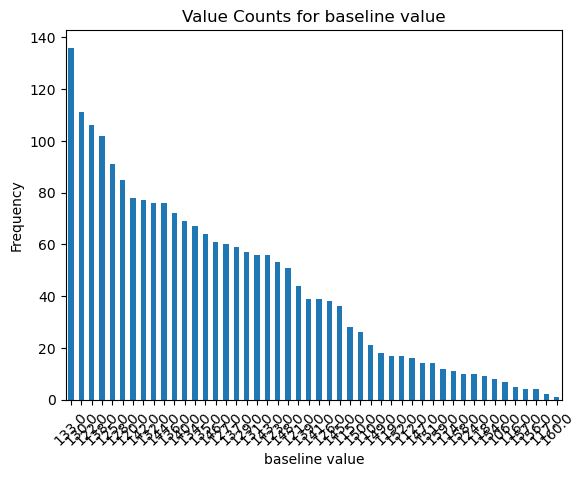

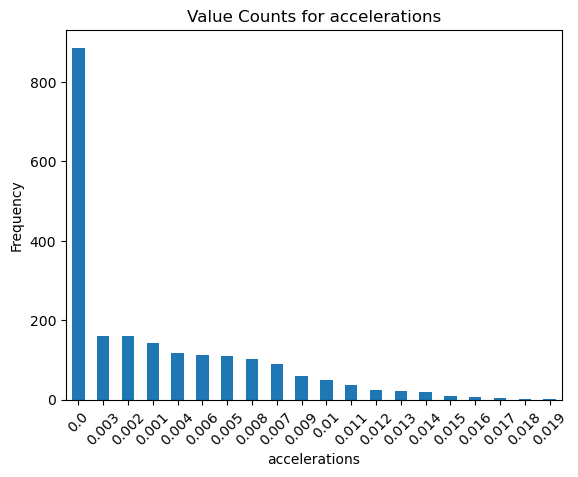

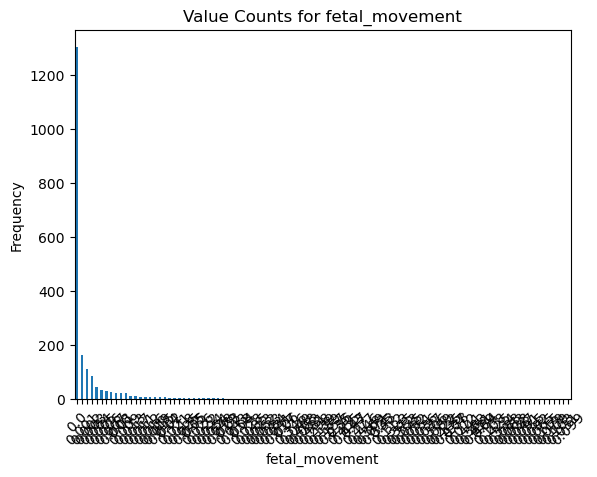

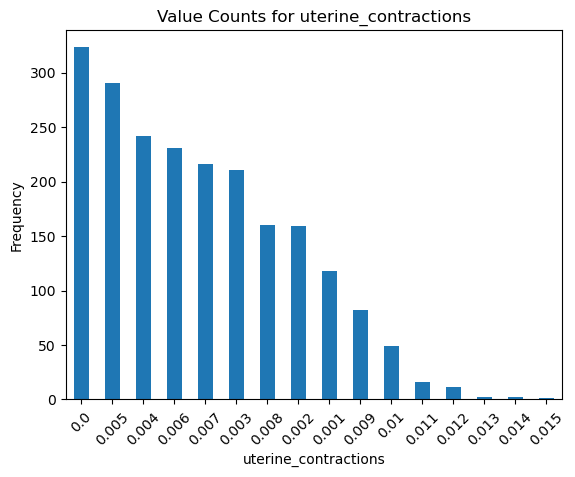

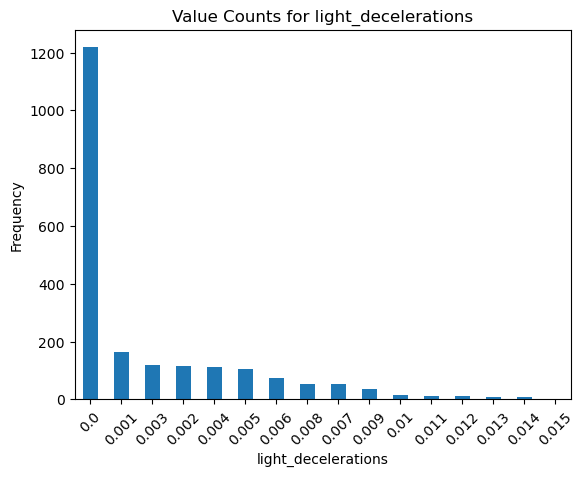

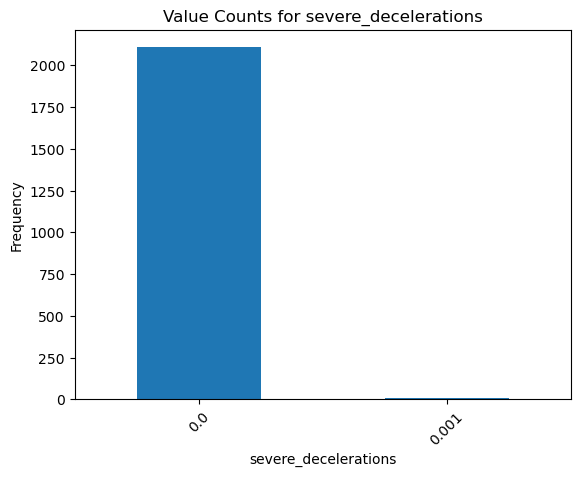

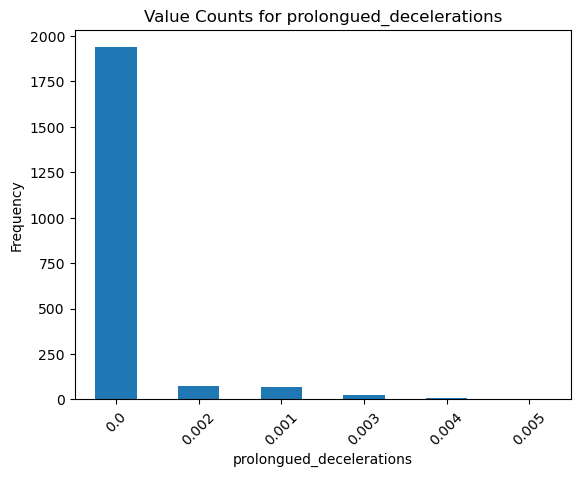

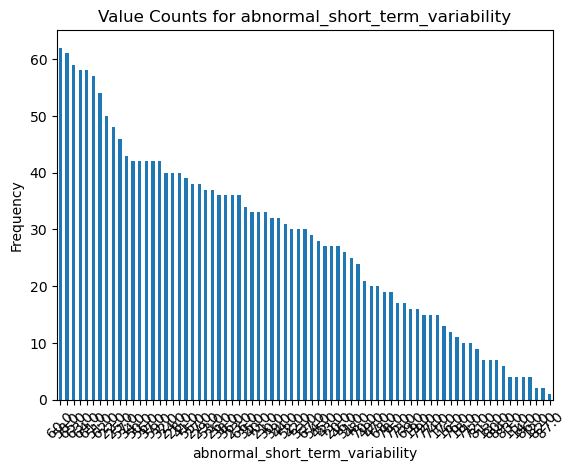

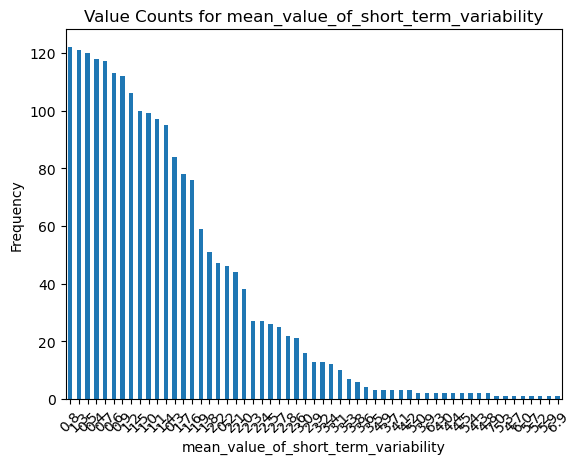

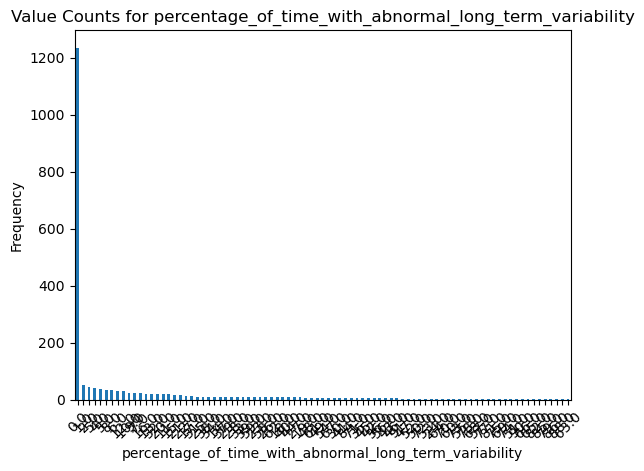

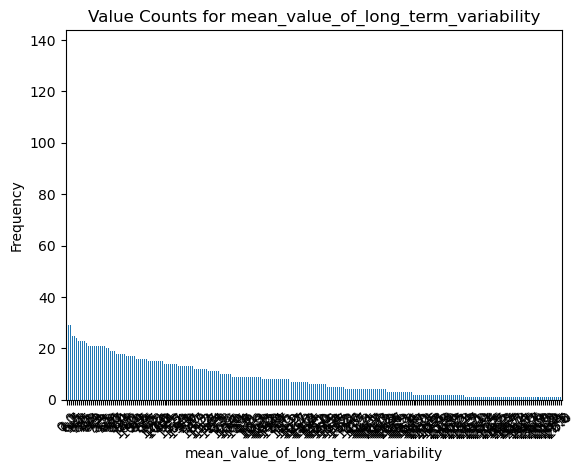

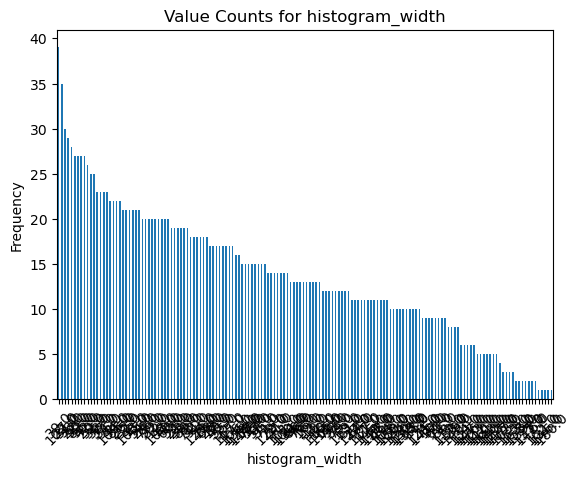

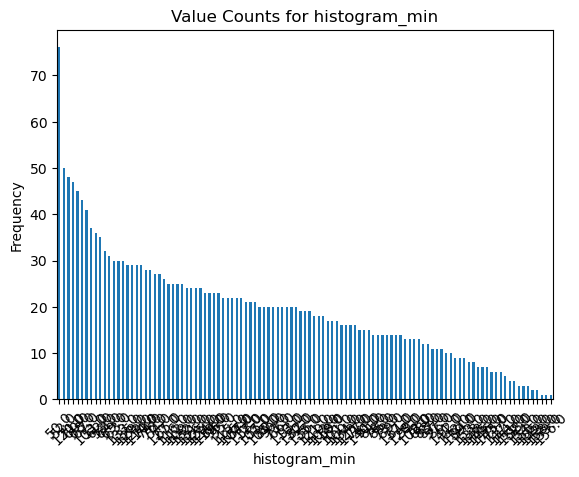

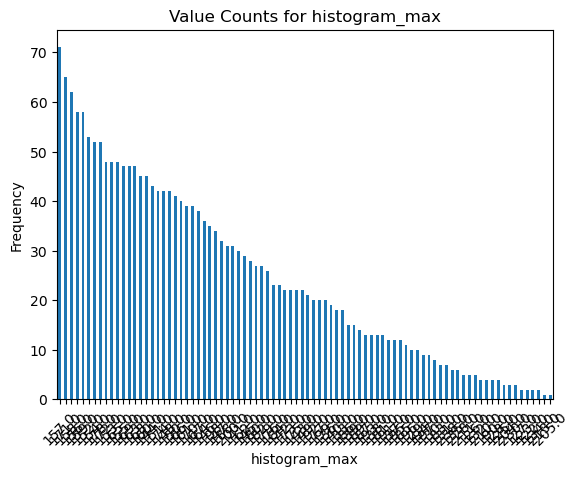

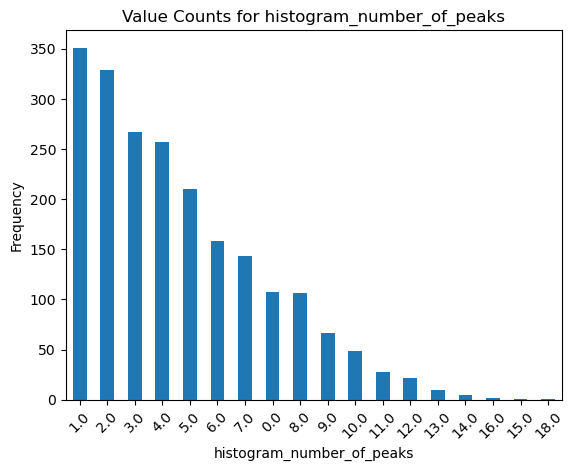

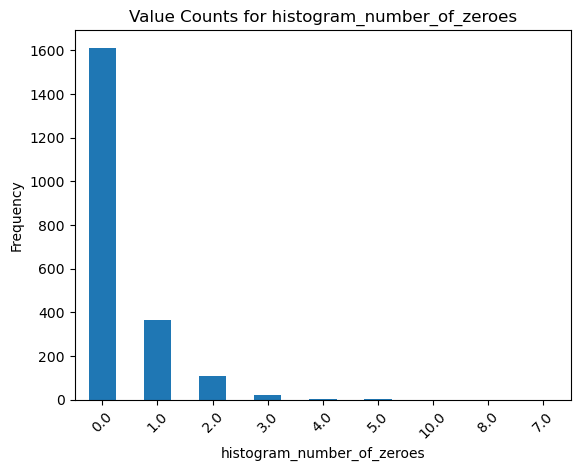

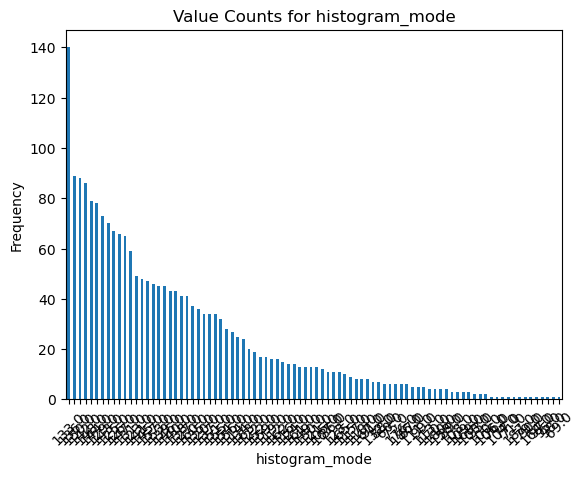

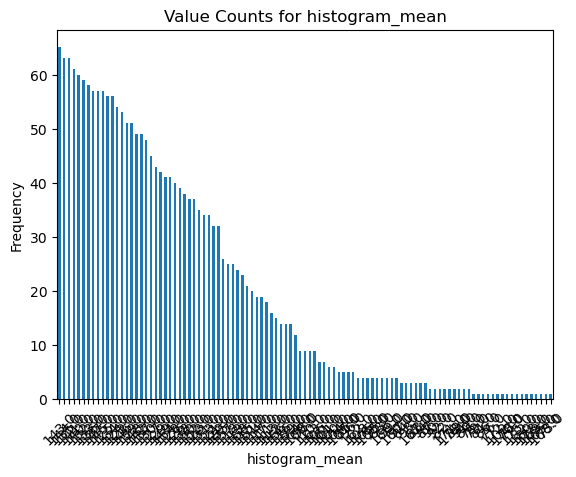

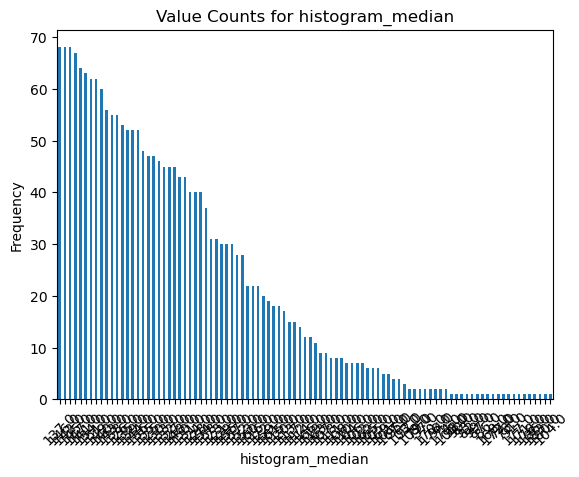

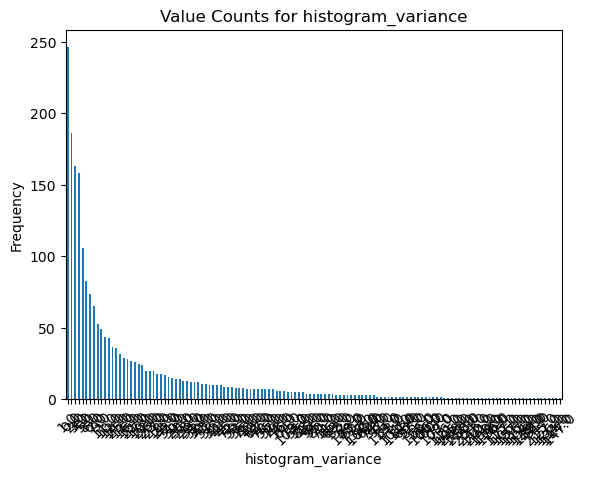

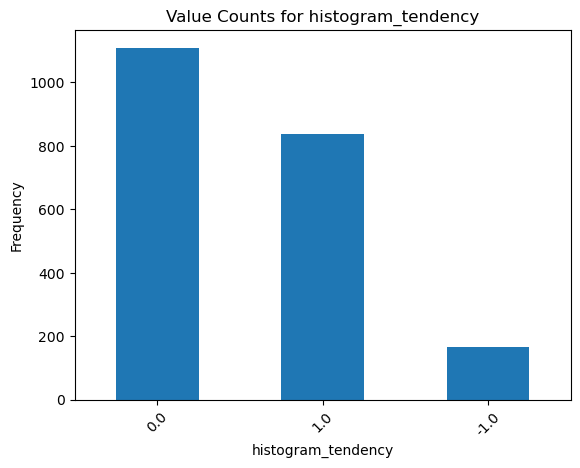

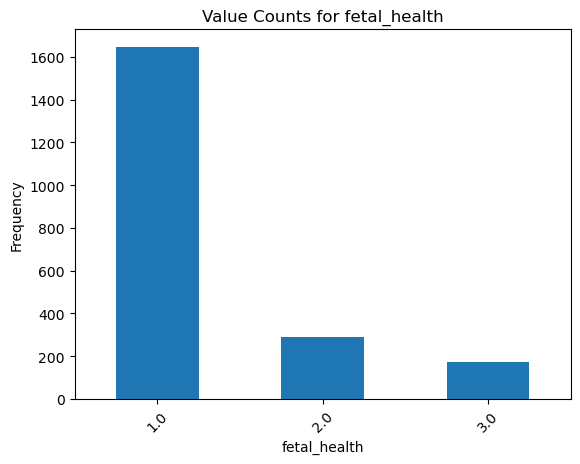

In [16]:
# Установка размера фигур для графиков
plt.figure(figsize=(12, 8))

# Цикл по всем столбцам датасета
for column in df.columns:
    plt.figure()
    df[column].value_counts().plot(kind='bar')
    plt.title(f'Value Counts for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Поворот подписей оси X для лучшей читаемости
    plt.show()

По графикам можно судить, что большинство признаков количественные непрерывные величины, хотя некоторые очень похожи на дискретные, но `histogram_tendency` точно дискретная величина, принимающая значения: -1, 0, 1. Скорее всего оно указывает на тендецию графика гистограммы, поэтому оставим без кодирования. А еще `severe_deceleration` выглядит крайне неинформативным, так как почти все значения равны нулю, и только малая часть — 0.001.

Также через boruta нашли неинформативных признака, которые лучше удалим: `'histogram_number_of_zeroes'`, `'histogram_tendency'`, `'severe_decelerations'`.

In [19]:
# разделим призники и таргет
features = df.drop(['fetal_health', 'histogram_number_of_zeroes', 'histogram_tendency', 'severe_decelerations'], axis=1)
target = df['fetal_health']

In [20]:
# разделим на трейн, валид и тест стратифицировано
feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, stratify=target, test_size=.25, random_state=RANDOM_STATE
)

In [21]:
# отмасшатабируем признаки тинмаксом
scaler = MinMaxScaler()
scaler.fit_transform(feature_train)

array([[0.25925926, 0.15789474, 0.        , ..., 0.49541284, 0.47706422,
        0.00823045],
       [0.27777778, 0.        , 0.        , ..., 0.35779817, 0.35779817,
        0.08641975],
       [0.7037037 , 0.10526316, 0.        , ..., 0.72477064, 0.71559633,
        0.06995885],
       ...,
       [0.51851852, 0.42105263, 0.002079  , ..., 0.65137615, 0.67889908,
        0.25102881],
       [0.83333333, 0.        , 0.        , ..., 0.70642202, 0.72477064,
        0.1563786 ],
       [0.5       , 0.        , 0.        , ..., 0.56880734, 0.56880734,
        0.06584362]])

In [22]:
feature_test = scaler.transform(feature_test)

## Обучение моделей

Обучим модель с использованием случайного леса и градиентного бустинга. Эти модели должны хорошо подойти для решения поставленной задачи. Для подбора гиперпараметров будем использовать Optuna.

In [25]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    random_state = RANDOM_STATE
    n_jobs = -1
    class_weight = 'balanced'
    
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        min_samples_split=min_samples_split, 
        n_jobs=n_jobs,
        random_state = random_state,
        class_weight=class_weight
    )
    score = cross_val_score(model, feature_train, target_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'random_forest')
        mlflow.log_param('n_estimators', n_estimators)
        mlflow.log_param('max_depth', max_depth)
        mlflow.log_param('min_samples_split', min_samples_split)
        mlflow.log_param('min_samples_leaf', min_samples_leaf)
        mlflow.log_metric('f1_score', max(score))
    
    return max(score)

In [26]:
study = optuna.create_study(direction='maximize')

In [27]:
# при повторных прогонах заново запускаться не будет для экономии времени 
# study.optimize(objective, n_trials=100)

In [28]:
#study.best_params

In [29]:
rf_best_params = {
    'n_estimators': 451,
     'max_depth': 10,
     'min_samples_leaf': 2,
     'min_samples_split': 2
}

In [30]:
#study.best_value

С подбором гиперпараметров мы получили наилучший результат взвешенного F1: `0.9411426135490742`. И параметры: 
```python
{'n_estimators': 451,
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2}
 ```
 Обучим модель на лучших гиперпараметрах и сохраним в трекинге.

In [32]:
random_forest_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', 
                                             random_state=RANDOM_STATE, **rf_best_params)
random_forest_model.fit(feature_train, target_train)
random_forest_preds = random_forest_model.predict(feature_test)

random_forest_f1 = f1_score(target_test, random_forest_preds, average='weighted')
with mlflow.start_run():
        random_forest_signature = infer_signature(target_test, random_forest_preds)
    
        mlflow.log_param('n_estimators', rf_best_params['n_estimators'])
        mlflow.log_param('max_depth', rf_best_params['max_depth'])
        mlflow.log_param('min_samples_split', rf_best_params['min_samples_split'])
        mlflow.log_param('min_samples_leaf', rf_best_params['min_samples_leaf'])
        mlflow.log_metric('f1_score', random_forest_f1)
        
        # Сохранение модели в MLFlow
        mlflow.sklearn.log_model(
        sk_model=random_forest_model,
        artifact_path="sklearn-model",
        signature=random_forest_signature,
        registered_model_name="fetal_health_RF",
    )

Registered model 'fetal_health_RF' already exists. Creating a new version of this model...
2024/06/26 10:14:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: fetal_health_RF, version 4
Created version '4' of model 'fetal_health_RF'.


In [33]:
# f1 на тестовой выборке
random_forest_f1

0.7143327788971575

Результат на тесте получился хуже, что, в принципе, ожидаемо.  Возможно, catboost сможет показать более лучший результат.

In [35]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 1e-4, 10, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': 0, 
        'thread_count': -1,
        'random_seed': RANDOM_STATE
    }

    model = CatBoostClassifier(**params)
    
    score = cross_val_score(model, feature_train, target_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'catboost')
        mlflow.log_param('iterations', params['iterations'])
        mlflow.log_param('depth', params['depth'])
        mlflow.log_param('learning_rate', params['learning_rate'])
        mlflow.log_param('l2_leaf_reg', params['l2_leaf_reg'])
        mlflow.log_param('bagging_temperature', params['bagging_temperature'])
        mlflow.log_param('random_strength', params['random_strength'])
        mlflow.log_param('border_count', params['border_count'])
        mlflow.log_metric('f1_score', max(score))
    
    return max(score)

In [36]:
study_catboost = optuna.create_study(direction='maximize')

In [37]:
# при повторных прогонах заново запускаться не будет для экономии времени 
# study_catboost.optimize(objective_catboost, n_trials=100)

In [38]:
# study_catboost.best_value

In [39]:
# study_catboost.best_params

In [40]:
catboost_best_params = {
     'iterations': 969,
     'depth': 7,
     'learning_rate': 0.011919242733076159,
     'l2_leaf_reg': 0.42636637260595084,
     'bagging_temperature': 0.6513894664277394,
     'random_strength': 0.0004861276373024065,
     'border_count': 195
}

Градиентынй бустинг показал чуть более лучшие результаты: `0.9569633541834159`, с гиперпараметрами:
```python
{'iterations': 969,
 'depth': 7,
 'learning_rate': 0.011919242733076159,
 'l2_leaf_reg': 0.42636637260595084,
 'bagging_temperature': 0.6513894664277394,
 'random_strength': 0.0004861276373024065,
 'border_count': 195}
```
Обучим модель отдельно и посмотрим, что будет на тестовой выборке.

In [42]:
catboost_model = CatBoostClassifier(thread_count=-1, auto_class_weights='Balanced', verbose=0,
                                             random_state=RANDOM_STATE, **catboost_best_params)
catboost_model.fit(feature_train, target_train)
catboost_preds = catboost_model.predict(feature_test)

catboost_f1 = f1_score(target_test, catboost_preds, average='weighted')

with mlflow.start_run():
        catboost_signature = infer_signature(target_test, catboost_preds)
    
        mlflow.set_tag('model', 'catboost')
        mlflow.log_param('iterations', catboost_best_params['iterations'])
        mlflow.log_param('depth', catboost_best_params['depth'])
        mlflow.log_param('learning_rate', catboost_best_params['learning_rate'])
        mlflow.log_param('l2_leaf_reg', catboost_best_params['l2_leaf_reg'])
        mlflow.log_param('bagging_temperature', catboost_best_params['bagging_temperature'])
        mlflow.log_param('random_strength', catboost_best_params['random_strength'])
        mlflow.log_param('border_count', catboost_best_params['border_count'])
        mlflow.log_metric('f1_score', catboost_f1)
        
        # Сохранение модели в MLFlow
        mlflow.sklearn.log_model(
            sk_model=catboost_model,
            artifact_path="sklearn-model",
            signature=catboost_signature,
            registered_model_name="fetal_health_RF_catboost",
        )

Registered model 'fetal_health_RF_catboost' already exists. Creating a new version of this model...
2024/06/26 10:14:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: fetal_health_RF_catboost, version 3
Created version '3' of model 'fetal_health_RF_catboost'.


In [43]:
catboost_f1

0.6935952313698224

Как мы видим, результат на тестовой выборке для случайного леса оказался лучше, чем для градиентного спуска, хотя на трейне было наоборот. Тогда имеет смысл использовать случайный лес, но можно проверить, улучшится ли качество, если оставить в датасете только важные признаки. Для отбора воспользуемся `boruta`.

In [45]:
# при повторном запуске блокнота выявленных признаков уже не будет
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=RANDOM_STATE)

# boruta_selector.fit(feature_train.values, target_train.values.ravel())

# select_train_f = boruta_selector.transform(feature_train.values)
# select_test_f = boruta_selector.transform(feature_test)

# rf.fit(select_train_f, target_train)
# boruta_preds = rf.predict(select_test_f)
# boruta_f1_score = f1_score(target_test, boruta_preds, average='weighted')

In [46]:
# взглянем на признаки
# selected_features_mask = boruta_selector.support_
# selected_features = feature_train.columns[selected_features_mask]
# selected_features

In [47]:
# что было удалено
# set(feature_train.columns.to_list()) - set(selected_features.to_list())